##### Imports

In [2]:
import sys, os
from asvFormula.digraph import *
from asvFormula.classesSizes.algorithmTime import measureGraphTime
import pandas as pd

## Experimentation

In [3]:
resultsFolder = 'results/graphData/'

naiveBayesWithPathFile = resultsFolder + 'naiveBayes.csv'
multiplePathsFile = resultsFolder + 'multiplePaths.csv'
balancedTreesFile = resultsFolder + 'balancedTrees.csv'

### Auxiliary Functions

In [3]:
printEnabled = True
def disablePrint():
    global printEnabled
    if printEnabled:
        sys._jupyter_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        printEnabled = False

def enablePrint():
    global printEnabled
    printEnabled = True
    sys.stdout.close()
    sys.stdout = sys._jupyter_stdout

def convertDictToCsv(dict, filename):

    df = pd.DataFrame.from_dict(dict, orient='index')

    # Save the DataFrame to a CSV file
    df.to_csv(filename)

### Time Naive Bayes

10 Children, 10 PathLength[12, 13, 14, 15, 16, 17, 18, 19]
Running for node 12 which has 256 equivalence classes
Node 12 took 0.13266277313232422 seconds to run
Running for node 13 which has 256 equivalence classes
Node 13 took 0.0635218620300293 seconds to run
Running for node 14 which has 256 equivalence classes
Node 14 took 0.07802128791809082 seconds to run
Running for node 15 which has 256 equivalence classes
Node 15 took 0.07158350944519043 seconds to run
Running for node 16 which has 256 equivalence classes
Node 16 took 0.0717310905456543 seconds to run
Running for node 17 which has 256 equivalence classes
Node 17 took 0.08822083473205566 seconds to run
Running for node 18 which has 256 equivalence classes
Node 18 took 0.07734227180480957 seconds to run
Running for node 19 which has 256 equivalence classes
Node 19 took 0.061896562576293945 seconds to run
10 Children, 11 PathLength[13, 14, 15, 16, 17, 18, 19, 20]
Running for node 13 which has 256 equivalence classes
Node 13 took 

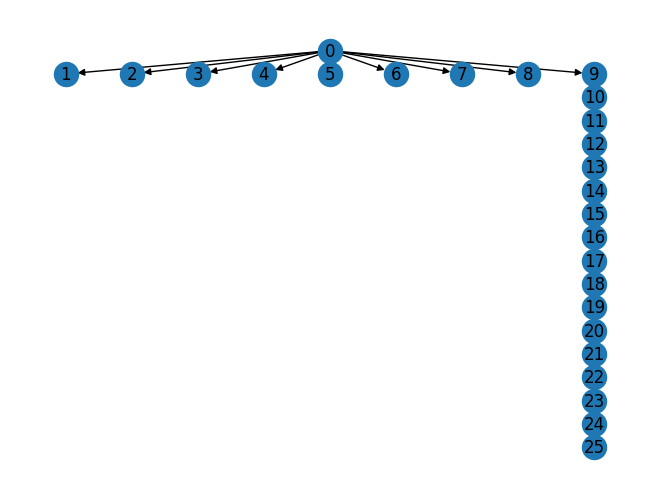

: 

In [5]:
def timeMultipleNaiveBayesWithPath(numNodes, pathLength, startFrom = 1):
    graphsResults = {}
    for i in range(startFrom,numNodes+1):
        for j in range(startFrom,pathLength+1):
            graphToEvaluate = naiveBayesWithPath(i, j)
            nodesToEvaluate = list(range(i+j-8, i+j))
            print(f'{i} Children, {j} PathLength' + str(nodesToEvaluate))
            graphsResults[f'{i} Children, {j} PathLength'] = measureGraphTime(graphToEvaluate, nodesToEvaluate)
            convertDictToCsv(graphsResults, naiveBayesWithPathFile)
    return graphsResults
    

numNodes = 20
pathLenght = 20
resNaiveBayes = timeMultipleNaiveBayesWithPath(numNodes, pathLenght,10)

### Time multiple Paths

In [ ]:
def timeMultiplePathsGraphs(numPaths, pathLength, startFrom = 1):
    graphsResults = {}
    for i in range(startFrom,numPaths+1):
        for j in range(startFrom,pathLength+1):
            graphToEvaluate = multiplePaths(i, j)
            #drawGraph(graphToEvaluate)
            nodesToEvaluate = list(range(0, j))
            print(f'{i} Paths, {j} Length' + str(nodesToEvaluate))
            graphsResults[f'{i} Paths, {j} Length'] = measureGraphTime(graphToEvaluate, nodesToEvaluate)
            convertDictToCsv(graphsResults, multiplePathsFile)

    return graphsResults
    

numberOfPaths = 8
pathLenght = 8
resMultiplePaths = timeMultiplePathsGraphs(numberOfPaths, pathLenght,4)

### Time balanced trees

In [ ]:
def timeMultipleBalancedTrees(numLevels, branchingFactor = 2, startLevels = 1, starBranching = 2):
    graphsResults = {}
    for i in range(startLevels,numLevels+1):
        for j in range(starBranching,branchingFactor+1):
            graphToEvaluate = balancedTree(i, j)
            #drawGraph(graphToEvaluate)
            leafNode = [node for node in graphToEvaluate.nodes if isLeaf(node, graphToEvaluate)][0]
            pathToLeaf = orderedNodes(graphToEvaluate, nx.ancestors(graphToEvaluate, leafNode)) + [leafNode]
            print(f'{i} Levels, {j} Branching' + str(pathToLeaf))
            graphsResults[f'{i} Levels, {j} Branching'] = measureGraphTime(graphToEvaluate, pathToLeaf)
            convertDictToCsv(graphsResults, balancedTreesFile)
            

    return graphsResults

numLevels = 2
branchingFactor =6

resBalancedTrees = timeMultipleBalancedTrees(numLevels, branchingFactor, 2, 3)


### Plotting the results 

In [ ]:
def dataframeFromCsv(filename):
    df = pd.read_csv(resultsFolder + filename, index_col=0)
    df.name = filename[:-4]
    return df


resultsFolder = '/results/graphData/'
naiveBayesFile = 'naiveBayes.csv'
multiplePathsFile = 'multiplePaths.csv'
balancedTreesFile = 'balancedTrees.csv'

naiveBayesDf = dataframeFromCsv(naiveBayesFile)
dfMultiplePaths = dataframeFromCsv(multiplePathsFile)
dfBalancedTrees = dataframeFromCsv(balancedTreesFile)

for column in ['allTopoSortsNumber', 'biggestEquivClasses', 'smallestEquivClasses']:
    for dataframe in [naiveBayesDf, dfMultiplePaths, dfBalancedTrees]:
        dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plotsResultsFolder = '/results/plots/'

def plotColumns(column1, column2, df, logScale = False):
    sns.set_theme(style='whitegrid')

    plt.figure(figsize=(10, 6))  # Set the figure size
    ax = sns.lineplot(x=column1, y=column2, data=df)

    if logScale:
        ax.set(xscale="log")
        # Define evenly spaced ticks for the x-axis
        min_tick = np.floor(np.log10(naiveBayesDf['allTopoSortsNumber'].min()))
        max_tick = np.ceil(np.log10(naiveBayesDf['allTopoSortsNumber'].max()))
        ticks = np.logspace(min_tick, max_tick, num=5)
        ax.set_xticks(ticks)

    ax.set_xlabel(column1)
    ax.set_ylabel(column2)
    ax.set_title(f'{column1} vs {column2}')

    plt.savefig(f'{plotsResultsFolder}{df.name}-{column1} vs {column2}.png')
    plt.close()
    
    #plt.show()

def plotGraphFamiliy(graphFamiliyData):
    plotColumns('allTopoSortsNumber', 'recursiveAverageTime', graphFamiliyData, True)
    plotColumns('averageEquivClasses', 'recursiveAverageTime', graphFamiliyData)
    plotColumns('averageEquivClasses', 'allTopoSortsNumber', graphFamiliyData)

In [ ]:
plotGraphFamiliy(naiveBayesDf)
plotGraphFamiliy(dfMultiplePaths)
plotGraphFamiliy(dfBalancedTrees)

### Optimization experiment

In [ ]:
from asvFormula.digraph import *
from asvFormula.classesSizes import equivalanceClassesSizesWithHashes


graphExample = multiplePaths(3,3)

for node in graphExample.nodes:
    classes = equivalanceClassesSizesWithHashes(graphExample, node)
    print(node)
